# Identifying Malaria using Blood Cell Images with Deep Transfer Learning (vgg19)

In [1]:
# we will need these as we are using transfer learning and we will have to train our own last layer(s)
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Sequential, Model, load_model

# importing pre-trained modeland a fuction to pre-process our image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

# for image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
# usual imports
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

### Datasets
Malaria Cell Images dataset:

https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [7]:
train_path = "/content/drive/MyDrive/Colab Notebooks/CNN/malaria_prognosis_vgg19/Dataset/Train"
valid_path = "/content/drive/MyDrive/Colab Notebooks/CNN/malaria_prognosis_vgg19/Dataset/Valid"

In [8]:
#useful for getting number of classes
folders = glob("/content/drive/MyDrive/Colab Notebooks/CNN/malaria_prognosis_vgg19/Dataset/Train/*")
folders

['/content/drive/MyDrive/Colab Notebooks/CNN/malaria_prognosis_vgg19/Dataset/Train/Uninfected',
 '/content/drive/MyDrive/Colab Notebooks/CNN/malaria_prognosis_vgg19/Dataset/Train/Parasitized']

### Downloading the pretrained VGG19 model with weights trained for ImageNet:

More Info.: https://keras.io/api/applications/

In [9]:
#resize all the images to this
image_size = [224, 224]

In [10]:
# we will not include last layer include_top=False
vgg = VGG19(input_shape=image_size+[3], weights="imagenet", include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [11]:
#don't train existing weights
for layer in vgg.layers:
    layer.trainable=False

### Model Construction

In [12]:
#our layers
x = Flatten()(vgg.output)

In [13]:
prediction = Dense(len(folders), activation="softmax")(x)

In [14]:
#create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [15]:
#view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
#image_data_augmentation
train_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2,
                            zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255)

training_set = train_datagen.flow_from_directory(train_path, batch_size=16,
                                                 target_size=(224, 224), class_mode="categorical")

validation_set = val_datagen.flow_from_directory(valid_path, batch_size=16,
                                                 target_size=(224, 224), class_mode="categorical")

Found 22358 images belonging to 2 classes.
Found 5200 images belonging to 2 classes.


In [19]:
# fit the model
r = model.fit(training_set, validation_data=validation_set, epochs=1,
                        steps_per_epoch=len(training_set), validation_steps=len(validation_set))

1398/1398 [==============================] - 9493s 7s/step - loss: 0.3818 - accuracy: 0.8507 - val_loss: 0.4379 - val_accuracy: 0.8452


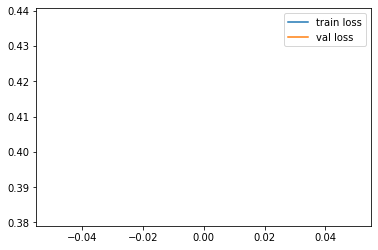

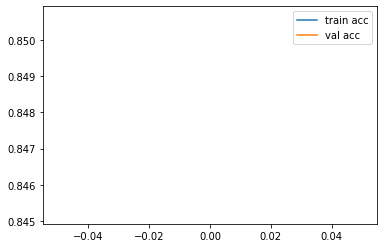

<Figure size 432x288 with 0 Axes>

In [20]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
y_pred = model.predict(validation_set)
y_pred

array([[5.2143075e-04, 9.9947864e-01],
       [9.9998689e-01, 1.3063616e-05],
       [7.1128295e-03, 9.9288720e-01],
       ...,
       [9.9642193e-01, 3.5780934e-03],
       [9.8730379e-01, 1.2696190e-02],
       [1.6723191e-02, 9.8327684e-01]], dtype=float32)

In [25]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 1, ..., 0, 0, 1])

In [26]:
#save the model as a h5 file
model.save("malaria_prognosis_vgg19.h5")

In [27]:
model=load_model("malaria_prognosis_vgg19.h5")

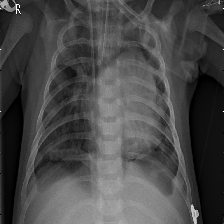

In [ ]:
img=load_img('/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Test/COVID/person100_bacteria_477.jpeg',target_size=(224,224))
img

In [ ]:
x=img_to_array(img)
x.shape

(224, 224, 3)

In [ ]:
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 224, 224, 3)

In [ ]:
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
pred = model.predict(img_data)
pred

array([[9.9999821e-01, 1.7789919e-06]], dtype=float32)

In [ ]:
pred_binary=np.argmax(pred, axis=1)
print(int(pred_binary))

0


In [ ]:
def predict_covid(filepath):
    img=load_img(filepath, target_size=(224,224))
    x=img_to_array(img)
    x=x/255
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    pred=model.predict(img_data)
    pred_binary=int(np.argmax(pred, axis=1))
    if pred_binary == 0:
    result = "COVID19"
    else:
    result = "NORMAL"
    return result

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Test/COVID/person100_bacteria_477.jpeg"
prediction = predict_covid(filepath)
prediction

'COVID'